# Diabetes diagnosis

In [4]:
import pandas as pd
import arff
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Load dataset

In [7]:
df_path = "../datasets/diabetes.arff"

def get_df(path):
    with open(df_path, 'r') as file:
        arff_data = arff.load(file)
    # Convert to pandas DataFrame
    df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])
    return df

df = get_df(df_path)

df

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/diabetes.arff'

## 1. Apply f_classif ##

In [10]:
y = df["Outcome"]
X = df.drop(columns="Outcome")

f_scores, p_values = f_classif(X, y)

# Criar um DataFrame para exibir as features e seus F-scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'F-score': f_scores})

# Ordenar pelo F-score (maior -> menor)
feature_scores = feature_scores.sort_values(by='F-score', ascending=False)

# Identificar a melhor (maior F-score) e pior (menor F-score) variável
best_feature = feature_scores.iloc[0]['Feature']
worst_feature = feature_scores.iloc[-1]['Feature']


NameError: name 'df' is not defined

## Plot the results ##
We discovered that glucose demonstrates the strongest discriminative capacity compared to the other variables. After that is BMI with a much lower discriminative power followed by age and number of pregenancies with very similar results. The feature that demonstrated the lowest discriminative power turned out to be blood preasure.

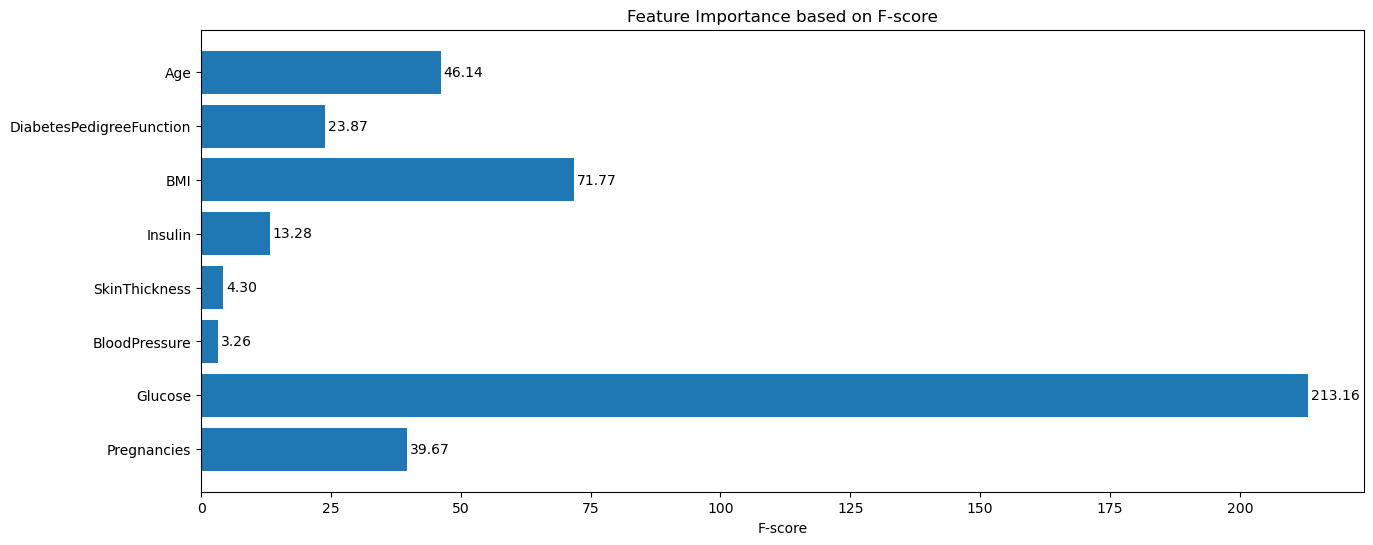

In [11]:
features = X.columns
plt.figure(figsize=(15, 6))
bars = plt.barh(features, f_scores, align='center')

#Adicionar o valor do F-score ao lado de cada barra
for bar, f_score in zip(bars, f_scores):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{f_score:.2f}', 
             va='center', ha='left', fontsize=10)


plt.xlabel('F-score')
plt.title('Feature Importance based on F-score')
plt.show()

<center>
   Fig. 1 - Bar graph displaying the F-scores for the different features
</center>

## Class-conditional Probabiliity Density Functions ##


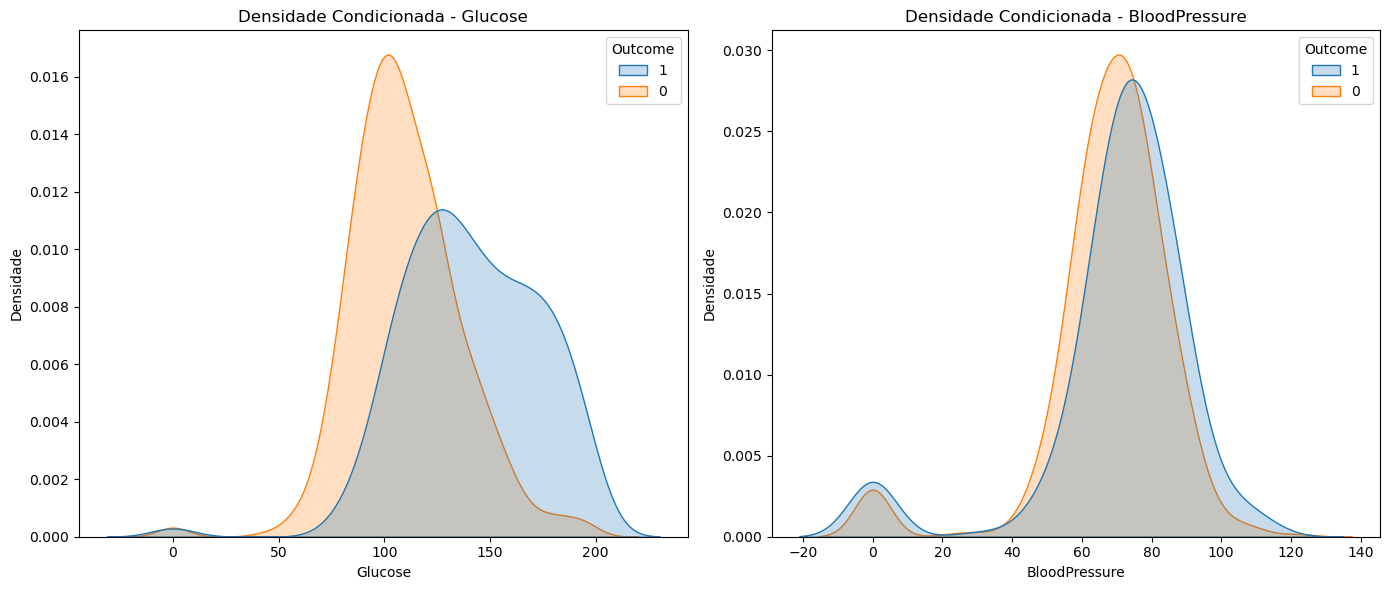

In [12]:
# Plotar a densidade para a melhor variável discriminativa
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(x=df[best_feature], hue=y, fill=True, common_norm=False)
plt.title(f'Probability Density Function - {best_feature}')
plt.xlabel(best_feature)
plt.ylabel('Density')

# Plotar a densidade para a pior variável discriminativa
plt.subplot(1, 2, 2)
sns.kdeplot(x=df[worst_feature], hue=y, fill=True, common_norm=False)
plt.title(f'Probability Density Function - {worst_feature}')
plt.xlabel(worst_feature)
plt.ylabel('Density')

plt.tight_layout()
plt.show()


<center>
    Fig. 2 -Illustrations of the class conditional density probability, in which the glucose variable produced the strongest discriminative power (highest F1-score, Fig. 1) and the blood pressure variable produced the least (lowest F1-score, Fig. 1). 
</center>

## 2. Decision tree classifier ##

In [9]:
tests_acc_avg = [] 
trains_acc_avg = [] 
min_sampl_splits = [2, 5, 10, 20, 30, 50, 100]
n_runs = 10  # Número de execuções


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Loop pelos valores de min_samples_split
for i in min_sampl_splits: 
    tests_acc = [] 
    trains_acc = [] 

    # n=10 runs para fazer média
    for j in range(n_runs): 

        clf = tree.DecisionTreeClassifier(min_samples_split=i) 
        clf.fit(X_train, y_train) 
        # Acurácias
        tests_acc.append(clf.score(X_test, y_test))  
        trains_acc.append(clf.score(X_train, y_train))  
    
    # Média das execuções
    tests_acc_avg.append(np.mean(tests_acc)) 
    trains_acc_avg.append(np.mean(trains_acc))

# Gráfico
plt.figure(figsize=(15, 6)) 
plt.scatter(min_sampl_splits, trains_acc_avg, label='Training accuracy')
plt.plot(min_sampl_splits, trains_acc_avg) 
plt.scatter(min_sampl_splits, tests_acc_avg, label='Testing accuracy') 
plt.plot(min_sampl_splits, tests_acc_avg)
plt.legend() 
plt.title('Training vs Testing Accuracies for different sample split minimums (Averaged over 10 runs)')
plt.grid(True)
plt.xlabel('Min samples split') 
plt.ylabel('Accuracy') 
plt.show()


NameError: name 'X' is not defined

<center>
    Fig. 3 - Scatterplot depicting the training and testing populations' accuracies' evolution (averaged over 10 runs)
</center>

## 3. Analyzing the results ##

The accuracy plot's first obvious finding is the overfitting tendency at lower min_samples_split values. The training accuracy of the model is around 1.0 for values like 2 or 5, while the testing accuracy is much lower. This implies that the tree is learning particular patterns that are not well-generalized to new data due to overfitting to the training set.
The tree gets simpler as min_samples_split rises, which lowers training accuracy (the model starts capturing less details), but raises testing accuracy, suggesting improved generalization.

For intermediate values of min_samples_split, such 30 and 50, where the difference between training and testing accuracy is smaller, the generalization ability increases. Testing accuracy begins to stabilize, indicating that the model is picking up valuable patterns without overfitting to the training set, even though it may not be as high as training accuracy.

Lastly, on the far end of the graph, for a value of min_sample_split of 100, the capacity of the model to discover complex correlations between the characteristics and the target variable is severely limited. Training accuracy significantly decreases at this high level because the tree becomes excessively shallow and generic. As a result, similar values are reached by the training and testing accuracies, which is a sign of underfitting. 

## 4. Max Depth 3 Tree ##
In summary, we can conclude that above average glucose levels combined with high BMI or normal range BMI with high glucose usually lead to diabetes. Also, extremely high BMI in people under the age of 28.5 typically have diabetes.

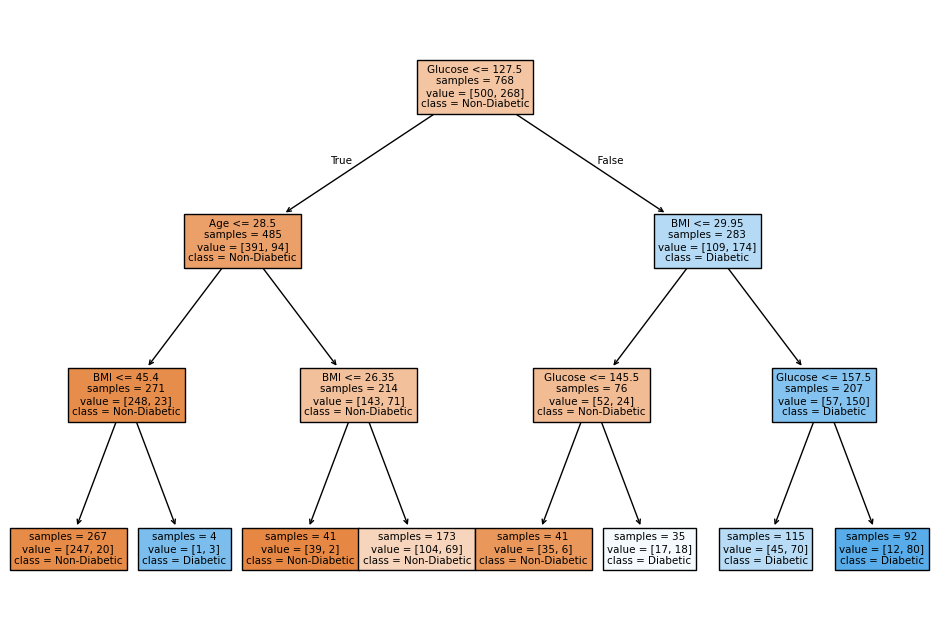

In [15]:
# Train the model
model_depth3 = DecisionTreeClassifier(random_state=1, max_depth=3)
model_depth3.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(model_depth3, filled=True, feature_names=X.columns, class_names=["Non-Diabetic", "Diabetic"], impurity = False)
plt.show()